In [84]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

from gensim import corpora, models, similarities
from collections import defaultdict

%matplotlib inline

In [85]:
# read clickbait.csv into a DataFrame
# documentation: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
url = '../data/clickbait.csv'
column_names = ["url","title","classification"]
clickbait = pd.read_csv(url,names=column_names,header=None)

# convert label to a numeric variable
clickbait['truth'] = clickbait.classification.map({'Fake':0, 'Truth':1})

clickbait.head()

,url,title,classification,truth
0,http://www.thedailymash.co.uk/news/internation...,Assange to be tempted from embassy with trail ...,Fake,0
1,http://christwire.org/2012/07/false-atheist-go...,The atheist god Flying Spaghetti Monster was s...,Fake,0
2,http://www.theleakywiki.com/index.php/k2-front...,"Child Consumes Pudding Before Meat, Long Time ...",Fake,0
3,http://nightlycitizen.com/2012/04/20/hitlers-b...,Marijuana Salvation Day,Fake,0
4,https://www.reddit.com/r/fakenews/comments/siv...,What's with the picture of a brick at the bott...,Fake,0


In [86]:
# define X and y
X = clickbait.title
y = clickbait.truth

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# use CountVectorizer to create document-term matrices from X_train and X_test
# include 1-grams and 2-grams, we end up with many features
vect = CountVectorizer(ngram_range=(1, 2))
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# rows are documents, columns are terms (aka "tokens" or "features")
X_train_dtm.shape

(450, 5255)

In [87]:
# last 50 features
print vect.get_feature_names()[-50:]

[u'worry', u'worry about', u'worth', u'worth 90k', u'worth of', u'worthless', u'worthless barack', u'would', u'would be', u'wrestling', u'wrestling fundraiser', u'wrestling to', u'write', u'write in', u'writes', u'writes resignation', u'wrongful', u'wrongful conception', u'wrongly', u'wrongly tagged', u'yachtsmen', u'yachtsmen rescued', u'year', u'year of', u'year old', u'year olds', u'years', u'years of', u'you', u'you all', u'you always', u'you betcha', u'you can', u'you do', u'you getting', u'your', u'your favorite', u'your fucking', u'yourself', u'yourself game', u'youtube', u'youtube celebrity', u'yukon', u'yukon when', u'zero', u'zero construction', u'zimbabwe', u'zimbabwe pm', u'znoneofthe', u'znoneofthe so']


In [88]:
# create document-term matrices
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# use Naive Bayes to predict the truth rating
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)

0.84


In [89]:
# calculate null accuracy
y_test_binary = np.where(y_test==5, 1, 0)
max(y_test_binary.mean(), 1 - y_test_binary.mean())

1.0

In [90]:
# define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test(vect):
    X_train_dtm = vect.fit_transform(X_train)
    print 'Features: ', X_train_dtm.shape[1]
    X_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    print 'Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)

In [91]:
# include up to 3-grams
tokenize_test(CountVectorizer(ngram_range=(1, 3)))

Features:  8233
Accuracy:  0.846666666667


In [92]:
# include just 1-grams
tokenize_test(CountVectorizer(ngram_range=(1, 1)))

Features:  2056
Accuracy:  0.84


In [93]:
# remove English stop words, ngram: 1-3
tokenize_test(CountVectorizer(stop_words='english',ngram_range=(1, 3)))

Features:  6090
Accuracy:  0.853333333333


In [94]:
# remove English stop words, ngram: 1-10
tokenize_test(CountVectorizer(stop_words='english',ngram_range=(1, 10)))

Features:  11033
Accuracy:  0.853333333333


In [95]:
# remove English stop words and only keep 100 features, ngram: 1-3
tokenize_test(CountVectorizer(stop_words='english', max_features=100, ngram_range=(1, 3)))

Features:  100
Accuracy:  0.633333333333


In [96]:
# include 1-grams thru 3-grams, and only include terms that appear at least 2 times
tokenize_test(CountVectorizer(ngram_range=(1, 3), min_df=2))

Features:  1876
Accuracy:  0.766666666667


In [97]:
# define a function that accepts text and returns a list of lemmas
def split_into_lemmas(text):
    text = unicode(text, 'utf-8').lower()
    words = TextBlob(text).words
    return [word.lemmatize() for word in words]

In [98]:
# use split_into_lemmas as the feature extraction function (WARNING: SLOW!)
tokenize_test(CountVectorizer(analyzer=split_into_lemmas))

Features:  2021
Accuracy:  0.833333333333


In [99]:
# Term Frequency
vect = CountVectorizer()
tf = pd.DataFrame(vect.fit_transform(X_train).toarray(), columns=vect.get_feature_names())
tf

,000,10,100,108,11,13,14,15,15th,16,...,year,years,you,your,yourself,youtube,yukon,zero,zimbabwe,znoneofthe
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
# Document Frequency - in how many documents does each word appear
vect = CountVectorizer(binary=True)
df = vect.fit_transform(X_train).toarray().sum(axis=0)
pd.DataFrame(df.reshape(1, 2056), columns=vect.get_feature_names())

,000,10,100,108,11,13,14,15,15th,16,...,year,years,you,your,yourself,youtube,yukon,zero,zimbabwe,znoneofthe
0,5,7,2,1,3,2,1,3,1,2,...,4,8,7,2,1,2,1,2,2,1


In [101]:
# Term Frequency-Inverse Document Frequency (simple version)
tf/df

,000,10,100,108,11,13,14,15,15th,16,...,year,years,you,your,yourself,youtube,yukon,zero,zimbabwe,znoneofthe
0,0.0,0.142857,0,0,0.000000,0,0,0,0,0,...,0,0.000,0,0,0,0,0,0,0.0,0
1,0.0,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000,0,0,0,0,0,0,0.0,0
2,0.0,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000,0,0,0,0,0,0,0.0,0
3,0.0,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000,0,0,0,0,0,0,0.0,0
4,0.0,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000,0,0,0,0,0,0,0.0,0
5,0.0,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000,0,0,0,0,0,0,0.0,0
6,0.0,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000,0,0,0,0,0,0,0.0,0
7,0.0,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000,0,0,0,0,0,0,0.0,0
8,0.0,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000,0,0,0,0,0,0,0.0,0
9,0.2,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000,0,0,0,0,0,0,0.0,0


In [102]:
# TfidfVectorizer
vect = TfidfVectorizer()
pd.DataFrame(vect.fit_transform(X_train).toarray(), columns=vect.get_feature_names())


## ideas
# word clouds visualizations
# tokenization
# tf/df
# gensim - topic modeling
# principle component analysis

,000,10,100,108,11,13,14,15,15th,16,...,year,years,you,your,yourself,youtube,yukon,zero,zimbabwe,znoneofthe
0,0.000000,0.265811,0,0,0.000000,0,0,0,0,0,...,0,0.000000,0,0,0,0,0,0,0.000000,0
1,0.000000,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000000,0,0,0,0,0,0,0.000000,0
2,0.000000,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000000,0,0,0,0,0,0,0.000000,0
3,0.000000,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000000,0,0,0,0,0,0,0.000000,0
4,0.000000,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000000,0,0,0,0,0,0,0.000000,0
5,0.000000,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000000,0,0,0,0,0,0,0.000000,0
6,0.000000,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000000,0,0,0,0,0,0,0.000000,0
7,0.000000,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000000,0,0,0,0,0,0,0.000000,0
8,0.000000,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000000,0,0,0,0,0,0,0.000000,0
9,0.290915,0.000000,0,0,0.000000,0,0,0,0,0,...,0,0.000000,0,0,0,0,0,0,0.000000,0


In [103]:
# create a document-term matrix using TF-IDF
vect = TfidfVectorizer(stop_words='english')
dtm = vect.fit_transform(clickbait.title)
features = vect.get_feature_names()
dtm.shape

(600, 2253)

In [104]:
def summarize():
    
    # choose a random title that is at least 50 characters
    linkTitle_length = 0
    while linkTitle_length < 50:
        linkTitle_id = np.random.randint(0, len(clickbait))
        linkTitle_text = unicode(clickbait.title[linkTitle_id], 'utf-8')
        linkTitle_length = len(linkTitle_text)
    
    # create a dictionary of words and their TF-IDF scores
    word_scores = {}
    for word in TextBlob(linkTitle_text).words:
        word = word.lower()
        if word in features:
            word_scores[word] = dtm[linkTitle_id, features.index(word)]
    
    # print words with the top 5 TF-IDF scores
    print 'TOP SCORING WORDS:'
    top_scores = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    for word, score in top_scores:
        print score
        print word
    
    # print 5 random words
    print '\n' + 'RANDOM WORDS:'
    random_words = np.random.choice(word_scores.keys(), size=3, replace=False)
    for word in random_words:
        print word
    
    # print the review
    print '\n' + linkTitle_text

In [105]:
summarize()

TOP SCORING WORDS:
0.386680102076
hit
0.386680102076
mcdonald
0.386680102076
pays
0.386680102076
breakfast
0.346708688926
shares

RANDOM WORDS:
breakfast
mcdonald
record

All-day breakfast pays off as McDonald's shares hit record high


In [106]:
summarize()

TOP SCORING WORDS:
0.426185631907
evolution
0.426185631907
confused
0.400415033186
poll
0.382130502408
ebola
0.367947918498
americans

RANDOM WORDS:
ebola
evolution
americans

New Poll Shows Americans Confused About Ebola, Evolution.


In [107]:
# Sentiment Analysis
sa_example = TextBlob(clickbait.title[0])
print sa_example
sa_example.sentiment.polarity

Assange to be tempted from embassy with trail of secrets


0.0

In [108]:
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [109]:
# create a new DataFrame column for sentiment (WARNING: SLOW!)
clickbait['sentiment'] = clickbait.title.apply(detect_sentiment)

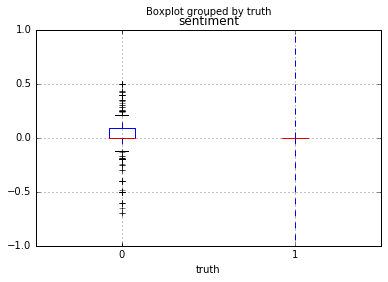

In [110]:
# box plot of sentiment grouped by stars
clickbait.boxplot(column='sentiment', by='truth')

In [111]:
# use logistic regression with text column only
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)
print metrics.accuracy_score(y_test, y_pred_class)

0.8


In [112]:
stoplist = set(CountVectorizer(stop_words='english').get_stop_words() )
texts = [[word for word in document.lower().split() if word not in stoplist] for document in list(X)]

In [113]:
# count up the frequency of each word
frequency = defaultdict(int)
for text in texts:
     for token in text:
         frequency[token] += 1
        
        

# remove words that only occur a small number of times
texts = [[token for token in text if frequency[token] > 1] for text in texts]

In [114]:
dictionary = corpora.Dictionary(texts)
print dictionary

Dictionary(1006 unique tokens: [u'9/11', u'kickstart', u'chinese', u'bull', u'alternatives']...)


In [125]:
# this objects stores everything we need for our bag of words representation
dictionary.doc2bow("New Poll Shows Americans Confused About Ebola, Evolution.".split())

[]

In [116]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [117]:
print(corpus[5])

[(37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)]


In [118]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=10, alpha = 'auto')
# warning, this takes a minute or two

In [119]:
lda.show_topics()

[u'0.019*news + 0.014*new + 0.011*police + 0.011*fake + 0.011*planned + 0.008*woman + 0.008*animal + 0.008*satire + 0.008*san + 0.008*francisco',
 u'0.016*woman + 0.008*man + 0.008*animal + 0.008*mass + 0.008*time + 0.008*end + 0.008*caressing + 0.008*wakes + 0.008*exotic + 0.008*school',
 u'0.016*secrets + 0.014*man + 0.011*navy + 0.011*military + 0.009*years + 0.009*charge + 0.009*intelligence + 0.009*allowed + 0.009*admiral + 0.009*tiger',
 u'0.010*dies + 0.010*worth + 0.010*cat + 0.009*man + 0.007*rat + 0.007*broadway + 0.007*government + 0.007*chinese + 0.007*just + 0.007*hair',
 u'0.013*man + 0.008*house + 0.008*days + 0.008*crash + 0.008*setting + 0.008*north + 0.008*day + 0.008*high + 0.008*coyotes + 0.008*10',
 u'0.009*new + 0.009*woman + 0.009*tennessee + 0.006*lebanon + 0.006*vulture + 0.006*israeli + 0.006*spy + 0.006*asks + 0.006*curriculum + 0.006*fucking',
 u'0.011*gets + 0.011*mexico + 0.011*donald + 0.008*following + 0.008*seeks + 0.008*alcohol + 0.008*wisconsin + 0.00

In [120]:
lda.show_topic(9)

[(0.022339185150228116, u'man'),
 (0.022337109647879508, u'new'),
 (0.011280217587027297, u'obama'),
 (0.0090684381676925541, u'film'),
 (0.009068229947791006, u'funeral'),
 (0.0090678949345084133, u'baby'),
 (0.0068566720194836277, u'porn'),
 (0.0068566477763324094, u'father'),
 (0.0068566151550784916, u'service'),
 (0.0068566109917476007, u'son')]

In [121]:
lda.top_topics(corpus, num_words=5)

[([(0.015722327692753776, u'secrets'),
   (0.01350818469871203, u'man'),
   (0.011293585081509558, u'navy'),
   (0.0112935382164844, u'military'),
   (0.0090792685141039779, u'years')],
  -19.075472117220098),
 ([(0.010553628629269418, u'gets'),
   (0.010553509243750706, u'mexico'),
   (0.010553022971316389, u'donald'),
   (0.0079794739817728964, u'following'),
   (0.0079794587515924342, u'seeks')],
  -24.735966410128),
 ([(0.013422004014204942, u'man'),
   (0.0081585468013657073, u'house'),
   (0.0081584716992821309, u'days'),
   (0.0081584599136410516, u'crash'),
   (0.0081584434421309773, u'setting')],
  -26.56363488079344),
 ([(0.0098208221252007889, u'dies'),
   (0.0098206222474113321, u'worth'),
   (0.0098205660318706582, u'cat'),
   (0.0090108999299696128, u'man'),
   (0.0074256039061426716, u'rat')],
  -30.15359246851088),
 ([(0.011475438679679479, u'police'),
   (0.011475245181771104, u'|'),
   (0.0086764605278671619, u'black'),
   (0.0086764153103190689, u'car'),
   (0.008676

In [122]:
lda2 = models.LdaModel(corpus, id2word=dictionary, num_topics=2, alpha = 'auto')
# warning, this takes a minute or two

In [123]:
lda2.show_topic(0)

[(0.0096032948792720892, u'new'),
 (0.0068168824506225018, u'man'),
 (0.0046781126553245176, u'news'),
 (0.0035582711581386714, u'day'),
 (0.0035419811204836812, u'time'),
 (0.0034481522339378816, u'city'),
 (0.0033595355164876355, u'obama'),
 (0.0033334269991041683, u'-'),
 (0.0032056283628453964, u'dies'),
 (0.0031640634979406518, u'dad')]

In [124]:
lda2.show_topic(1)

[(0.013241844558474779, u'man'),
 (0.0082473806540897324, u'woman'),
 (0.0058026494695824701, u'police'),
 (0.0045863424229911076, u'porn'),
 (0.0043037344096544319, u'new'),
 (0.0041954716293883115, u'gets'),
 (0.003759296807847522, u'planned'),
 (0.0036537760731121015, u'using'),
 (0.0034359890117798488, u'school'),
 (0.0033788778241846096, u'teen')]